In [1]:
import pandas as pd
from datasets import Dataset

d:\python\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [35]:
data = pd.read_csv("IMDB Dataset.csv", index_col=False)
data["sentiment"] = data["sentiment"].map({"negative":0, "positive":1})
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [24]:
dataset = Dataset.from_pandas(data)

In [3]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

In [25]:
def preprocess_function(examples):
    return tokenizer(examples["review"], truncation=True, padding="max_length")

In [26]:
tokenized_dataset = dataset.map(preprocess_function, batched=True)

Map: 100%|██████████| 50000/50000 [00:22<00:00, 2262.62 examples/s]


In [6]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
import evaluate

accuracy = evaluate.load("accuracy")
precision = evaluate.load("precision")
recall = evaluate.load("recall")
f1 = evaluate.load("f1")
accuracy = evaluate.load("accuracy")

In [ ]:
import numpy as np


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    return {
        "accuracy": accuracy.compute(predictions=predictions, references=labels)["accuracy"],
        "precision": precision.compute(predictions=predictions, references=labels)["precision"],
        "recall": recall.compute(predictions=predictions, references=labels)["recall"],
        "f1": f1.compute(predictions=predictions, references=labels)["f1"],
    }

In [9]:
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}

In [10]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
from sklearn.model_selection import train_test_split
data_train, data_test = train_test_split(data, test_size=0.2, random_state=42)

In [ ]:
def tokenize_function(example):
    return tokenizer(example["review"], padding="max_length", truncation=True)

train_dataset = Dataset.from_pandas(data_train.reset_index(drop=True))
eval_dataset = Dataset.from_pandas(data_test.reset_index(drop=True))

train_dataset = train_dataset.map(tokenize_function, batched=True)
eval_dataset = eval_dataset.map(tokenize_function, batched=True)

train_dataset = train_dataset.remove_columns(["review"])
eval_dataset = eval_dataset.remove_columns(["review"])

def add_labels(example):
    example["labels"] = example["sentiment"]
    return example

train_dataset = train_dataset.map(add_labels)
eval_dataset = eval_dataset.map(add_labels)

train_dataset = train_dataset.remove_columns(["sentiment"])
eval_dataset = eval_dataset.remove_columns(["sentiment"])


Map: 100%|██████████| 10000/10000 [00:00<00:00, 17825.07 examples/s]


In [37]:
training_args = TrainingArguments(
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

C:\Users\tomin\AppData\Local\Temp\ipykernel_23592\78129325.py:13: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
d:\python\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [ ]:
#EVALUATE MODEL ON TEST SET
eval_results = trainer.evaluate()
print("\n=== TRANSFORMER MODEL PERFORMANCE ===")
print(eval_results)

  0%|          | 0/125 [00:00<?, ?it/s]


=== TRANSFORMER MODEL PERFORMANCE ===
{'eval_loss': 0.29022371768951416, 'eval_accuracy': 0.896, 'eval_precision': 0.9023354564755839, 'eval_recall': 0.8799171842650103, 'eval_f1': 0.8909853249475892, 'eval_runtime': 128.4223, 'eval_samples_per_second': 7.787, 'eval_steps_per_second': 0.973, 'epoch': 1.0}


In [ ]:
# GET PREDICTIONS
predictions = trainer.predict(eval_dataset)
pred_labels = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

  0%|          | 0/125 [00:00<?, ?it/s]

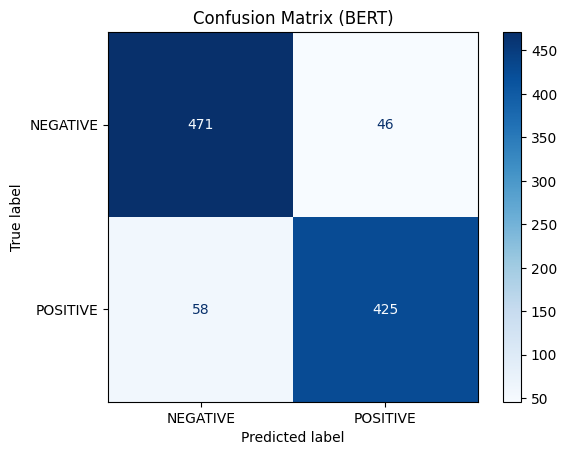

In [ ]:
#CONFUSION MATRIX
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(cm, display_labels=["NEGATIVE", "POSITIVE"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (BERT)")
plt.show()

In [ ]:
# BASELINE MODEL (TF-IDF + Logistic Regression)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Using the SAME train-test split as BERT
baseline_train = data_train
baseline_test = data_test

vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(baseline_train["review"])
X_test = vectorizer.transform(baseline_test["review"])

y_train = baseline_train["sentiment"]
y_test = baseline_test["sentiment"]

baseline_model = LogisticRegression(max_iter=200)
baseline_model.fit(X_train, y_train)

baseline_preds = baseline_model.predict(X_test)

print("\n=== BASELINE MODEL (TF-IDF + Logistic Regression) ===")
print(classification_report(y_test, baseline_preds))


=== BASELINE MODEL (TF-IDF + Logistic Regression) ===
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      4961
           1       0.89      0.91      0.90      5039

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

